# Notebook for the execution of my RL agent with NLP

In this notebook, I will be training a Reinforcement Learning (RL) agent to trade stocks using a combination of stock price data and NLP. The agent will be trained to make buy/sell/hold decisions based on the stock price data and the sentiment of a given NLP phrase. The agent will be trained using a Deep Q-Learning algorithm and will be tested on a separate set of stock price data. The agent will be trained to maximize the total profit made from trading stocks. 

For ease of execution, this is structured as a notebook but can be converted to a python script for production where a user inputs the phrase at the start of testing and/or training.

### Useful Imports

In [1]:
# Import useful Python libraries.

from collections import deque
import random
import time
import calendar
import datetime
from datetime import date, timedelta

from transformers import BertForSequenceClassification, BertTokenizer

import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as pdr
import yfinance as yf
import ccxt
import mplfinance as mpf

from sklearn.preprocessing import StandardScaler

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
from scipy.stats import f_oneway

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-03-24 21:29:16.108189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data getter functions using yfiniance

Functions to get stock data from yfinance

In [2]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    return stock_data

def get_data(start_date, end_date, tickers=['GOOG', '^GSPC', 'GC=F']):
    '''
    get data from yf for tickers 
    :return: dataframe
    '''
    # get data
    stock_data = {}
    for ticker in tickers:
        stock_data[ticker] = get_stock_data(ticker, start_date, end_date)
        
    return stock_data

## Data Parameters

Define the data parameters for training, testing, stock used and RL agent parameters

In [3]:
start_date_training = '2016-01-01' # Data start date
end_date_training = '2020-12-31' # Data end date

start_date_test = '2021-01-01' # Test Data start date
end_date_test = '2021-12-31' # Test Data end date

tickers=['GOOG', '^GSPC', 'GC=F']  # Stocks
num_stocks = len(tickers)  # Number of stocks

## Fetch data and add relevant columns

Fetch data from yfinance, drop days of trading not common betwwen the stocks and add pct_change and moving averages

In [4]:
train_data = get_data(start_date_training, end_date_training, tickers)
test_data = get_data(start_date_test, end_date_test, tickers)

# Identify common trade days for training data and drop days not in common
common_trade_days_train = set(train_data[tickers[0]].index) # Initialize with the first ticker's dates
for ticker in tickers[1:]: # Loop through the rest of the tickers
    common_trade_days_train = common_trade_days_train.intersection(set(train_data[ticker].index))
for ticker in tickers:
    train_data[ticker] = train_data[ticker].loc[list(common_trade_days_train)]

# Identify common trade days for testing data and drop not in common
common_trade_days_test = set(test_data[tickers[0]].index) # Initialize with the first ticker's dates
for ticker in tickers[1:]: # Loop through the rest of the tickers
    common_trade_days_test = common_trade_days_test.intersection(set(test_data[ticker].index))
for ticker in tickers:
    test_data[ticker] = test_data[ticker].loc[list(common_trade_days_test)]

for ticker in tickers:
    train_data[ticker] = train_data[ticker].sort_index()
    test_data[ticker] = test_data[ticker].sort_index()
 
for ticker in tickers:
    # add daily_pct_change
    train_data[ticker]['daily_pct_change'] = (train_data[ticker]['Adj Close']- train_data[ticker]['Adj Close'].shift(-1))/train_data[ticker]['Adj Close'].shift(-1)*100
    test_data[ticker]['daily_pct_change'] = (test_data[ticker]['Adj Close']- test_data[ticker]['Adj Close'].shift(-1))/test_data[ticker]['Adj Close'].shift(-1)*100
    # add MAV
    for window in [3, 6, 9]:
        train_data[ticker][f'{window}d_mav'] = train_data[ticker]['Adj Close'].rolling(window=window).mean()
        test_data[ticker][f'{window}d_mav'] = test_data[ticker]['Adj Close'].rolling(window=window).mean()

list_dates_training = list(train_data[list(train_data.keys())[0]].index)
list_dates_test = list(test_data[list(test_data.keys())[0]].index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
train_data['GOOG']['Adj Close']

Date
2016-01-04    37.091999
2016-01-05    37.129002
2016-01-06    37.181000
2016-01-07    36.319500
2016-01-08    35.723499
                ...    
2020-12-23    86.619003
2020-12-24    86.942497
2020-12-28    88.804497
2020-12-29    87.935997
2020-12-30    86.975998
Name: Adj Close, Length: 1255, dtype: float64

In [6]:
train_data['^GSPC']['Adj Close']

Date
2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
2016-01-08    1922.030029
                 ...     
2020-12-23    3690.010010
2020-12-24    3703.060059
2020-12-28    3735.360107
2020-12-29    3727.040039
2020-12-30    3732.040039
Name: Adj Close, Length: 1255, dtype: float64

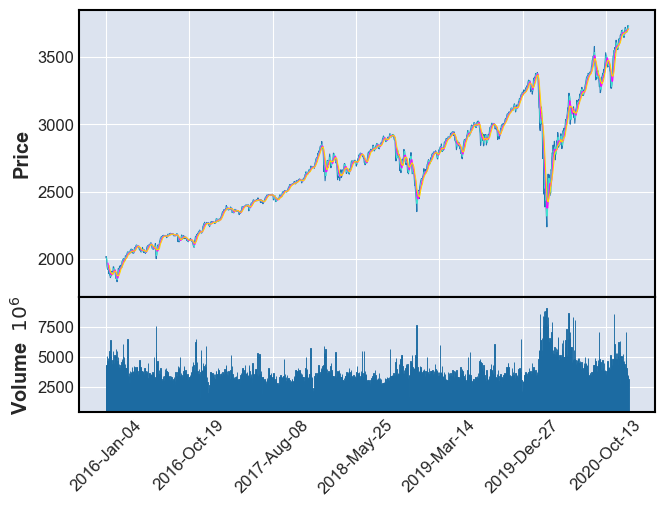

In [7]:
mpf.plot(train_data['^GSPC'],type='line', mav=(3,6,9),volume=True)

### Normalize Data

This cell normalizes the data. However, the normalized data is not used to train the agent. The agent uses the raw data to make decisions as normalizing prices would not allow the agent to buy and sell with the correct amount of money. 

In [8]:
# ## Normalize Data --> NOT USED IN THE AGENT AT THE MOMENT
# train_data_norm = train_data.copy()
# test_data_norm = test_data.copy()
# features = ['Open', 'Close', 'Adj Close', 'Volume', 'daily_pct_change', '3d_mav', '6d_mav', '9d_mav']
# 
# for ticker in tickers:
#     scaler = StandardScaler()
#     scaler = scaler.fit(train_data[ticker][features])
#     train_data_norm[ticker][features] = scaler.transform(train_data[ticker][features])
#     # Apply the same scaler to the test data
#     test_data_norm[ticker][features] = scaler.transform(test_data[ticker][features])
# 
#     #rename features to have ticker name in front
#     train_data_norm[ticker] = train_data_norm[ticker].add_prefix(f'{ticker}_')
#     test_data_norm[ticker] = test_data_norm[ticker].add_prefix(f'{ticker}_')

## Create state vector

In [9]:
# Concatenate Data to create the state vector

#not normalized
state_t = np.concatenate([train_data[ticker] for ticker in tickers], axis = 1) # state_t.shape = (1255,30)

# normalized
#state_t = np.concatenate([train_data_norm[ticker] for ticker in tickers], axis = 1) # state_t.shape = (1255,30)

print('state shape: ', state_t.shape)

state shape:  (1255, 30)


In [10]:
state_t

array([[  37.15000153,   37.20299911,   36.56290054, ...,           nan,
                  nan,           nan],
       [  37.32249832,   37.59999847,   36.93199921, ...,           nan,
                  nan,           nan],
       [  36.5       ,   37.35900116,   36.44599915, ..., 1081.80000814,
                  nan,           nan],
       ...,
       [  87.58174896,   89.53639984,   87.31674957, ..., 1877.26664225,
        1877.21663411, 1873.2110867 ],
       [  89.38950348,   89.62200165,   87.80449677, ..., 1878.93330892,
        1876.21663411, 1876.25552029],
       [  88.10050201,   88.25475311,   86.27999878, ..., 1882.63330078,
        1878.18330892, 1880.13330078]])

## NLP Model

Import Pre-trained NLP model

In [11]:
class NLPModel:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        checkpoint_path = './' + 'model_without_language_model.ckpt'
        self.model.load_state_dict(torch.load(checkpoint_path,  map_location=torch.device('cpu') ))
        self.model.eval()
        self.max_length = 256
        
    def preprocess_for_bert(self, query):
        tokens = self.tokenizer.encode_plus(query, max_length=self.max_length, truncation=True, padding="max_length", return_tensors="pt")
        return tokens["input_ids"], tokens["attention_mask"]

    def classify(self, text):  # Assuming single text input
        input_ids, attention_mask =self.preprocess_for_bert(text)
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1).numpy()
        return predictions[0] 



In [12]:
# Integration with trading agent
nlp_model = NLPModel()

# Test output is 0 for low risk, 1 for medium risk, 2 for high risk
nlp_model.classify("I want quick risky profits")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2

## Agent

In [13]:
class Trader:

    def __init__(self, state_size, window_size, trend, skip, batch_size, tickers, transaction_cost = 0.0, risk_level=1):

        self.state_size = state_size #30 (10 variables * 3)
        self.window_size = window_size
        self.half_window = window_size // 2 # Round the result down to the nearest whole number.
        self.trend = trend  # TREND should be an array of time t and at each t a dict with ticker [0]{AAPL: zzz, GOOG:xxx,...}
        self.skip = skip
        self.action_size = len(tickers) * len(tickers) * 3  # For GOOG, ^GSPC', GC=F # Action 0 -> Hold; Action 1 -> Buy; Action 2 -> Sell.
        self.batch_size = batch_size
        self.replay_frequency = 40
        self.memory = deque(maxlen = 1000)
        self.tickers = tickers
        self.inventory = {f'{ticker}':[] for ticker in self.tickers}
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.transaction_cost = transaction_cost

        # state trackers
        self.historical_prices = {f'{ticker}':[] for ticker in self.tickers}
        self.volatility = {ticker: 0 for ticker in tickers}
        self.sharpe_ratio = {ticker: 0 for ticker in tickers}
        self.risk_free_rate = 0.01  # Assuming a risk-free rate of 1% for Sharpe ratio

        # agent NLP parameters
        self.risk_level = risk_level # 0=low, 1=med, 2=high
        self.time_horizon = 1 # 0=short, 1=med, 2=long
        
        # reward modifiers and thresholds
        self.high_volatility_threshold = 0.12
        self.high_sharpe_ratio_threshold = 0.5
        self.reward_multiplier = 1.2
        
        
        # NETWORK
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()

        # TensorFlow placeholder for the input state of the network. ("None", state size) - None for any batch size
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        # TensorFlow placeholder for the output action of the network, second dimension is the size of the action vector.
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])

        # Create a fully connected layer with 256 units and ReLU activation function.
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        feed2 = tf.layers.dense(feed, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        #self.logits = tf.layers.dense(feed2, self.action_size)


        # MSE between network and target action
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))

        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(self.cost)

        # Initialize all variables in the TensorFlow graph.
        self.sess.run(tf.global_variables_initializer())

    def update_metrics(self, tickers, new_price):
        for ticker in tickers:
            ticker_new_price = new_price[ticker]
            self.historical_prices[ticker].append(ticker_new_price)
            if len(self.historical_prices[ticker]) > 1:
                returns = self.calculate_daily_returns(self.historical_prices[ticker])
                self.volatility[ticker] = self.calculate_volatility(returns)
                self.sharpe_ratio[ticker] = self.calculate_sharpe_ratio(returns, self.risk_free_rate)

    def calculate_daily_returns(self, prices):
        prices = np.array(prices)
        returns = np.diff(prices) / prices[:-1]
        return returns

    def calculate_volatility(self, returns):
        volatility = np.std(returns) # should I divide by window size?
        return volatility

    def calculate_sharpe_ratio(self, returns, risk_free_rate):
        mean_return = np.mean(returns)
        volatility = np.std(returns)
        if volatility == 0:
            return 0
        sharpe_ratio = (mean_return - risk_free_rate) / volatility
        return sharpe_ratio

    def act(self, state):
        """
        Selects an action to take given a state.

        Args:
        state: The state of the environment.

        Returns:
        The action to take (an integer).
        """        
        # If a random number is less than the exploration rate --> random action.
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        # Include the batch dimension
        state = state.reshape(1, -1)  # This changes shape from (30,) to (1, 30)

        # Else select the action with the highest probability (the highest output value from the logits layer).
        action_probs = self.sess.run(self.logits, feed_dict={self.X: state})[0]
        
        # Adjust action probabilities based on risk level
        action_probs = self.adjust_action_probs(action_probs)
        
        action = np.argmax(action_probs)
        return action

    
    def adjust_action_probs(self, action_probs):
        modifier_threshold = 0.15
        for i, agent_action in enumerate(action_probs):
            action = self.decode_action(i)
            # count the number of 'hold' in the action vector
            hold_count = action.count('hold')
            # if risk level is 2, penalize by reducing the probability based on number of holds
            if self.risk_level == 2:
                action_probs[i] *= (1 - modifier_threshold * (hold_count / len(action)))
            # if risk level is 0, reward by increasing the probability based on number of holds
            elif self.risk_level == 0:
                action_probs[i] *= (1 + modifier_threshold * (hold_count / len(action)))

        return action_probs
    
    def get_state(self, t, window_size, trend=None):
        """
        Constructs the state representation for timestep `t` from the class's trend data.
        
        Args:
        - t: Current timestep.
        - window_size: Number of timesteps to include in the state for historical context.
        
        Returns:
        - A numpy array representing the current state.
        """
        if trend is None:
            trend = self.trend
            
        d = t - window_size + 1
        state = []
        
        for i in range(d, t + 1):
            if i >= 0:
                # Append the Adj Close prices for each ticker at timestep i
                state.append([trend[i][ticker] for ticker in self.tickers])
            else:
                # If i is negative, it means we don't have enough data --> pad w zero
                state.append([0 for _ in self.tickers])
        
        flat_state = np.array(state).flatten()
        return flat_state


    def decode_action(self, action):
        """
        Decode a single action integer into actions for each stock.
        
        Args:
        - action (int): The action integer.
        
        Returns:
        - A tuple of actions for each of the three stocks.
        """
        # TODO make independent of number of stocks
        actions = ['hold', 'buy', 'sell']
        s1_action = action // 9  # Determine action for stock 1
        s2_action = (action % 9) // 3  # Determine action for stock 2
        s3_action = action % 3  # Determine action for stock 3
        
        return (actions[s1_action], actions[s2_action], actions[s3_action])

    def replay(self, batch_size):
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
    
        # Initialize arrays for states, actions, rewards, next states, and done flags
        states = np.array([transition[0] for transition in mini_batch])
        actions = np.array([transition[1] for transition in mini_batch])
        rewards = np.array([transition[2] for transition in mini_batch])
        next_states = np.array([transition[3] for transition in mini_batch])
        done_flags = np.array([transition[4] for transition in mini_batch])
    
        # Predict Q-values for current states and next states
        Q_values_current = self.sess.run(self.logits, feed_dict={self.X: states})
        Q_values_next = self.sess.run(self.logits, feed_dict={self.X: next_states})
    
        # Initialize target Q-values array
        target_Q_values = Q_values_current.copy()
    
        # Update the Q-values based on the action taken
        for i in range(batch_size):
            action = actions[i]
            if done_flags[i]:
                target_Q_values[i, action] = rewards[i]
            else:
                target_Q_values[i, action] = rewards[i] + self.gamma * np.amax(Q_values_next[i])
    
        # Train the neural network
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X: states, self.Y: target_Q_values})
    
        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
        return cost
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            self.reset_inventory()
            total_profit = 0
            state = self.get_state(0, self.window_size)
            starting_money = initial_money
            last_prices = {ticker: 0 for ticker in self.tickers}  # Track last prices for inventory valuation

            for t in range(0, len(self.trend) - 1, self.skip):
                current_prices = {ticker: self.trend[t + 1][ticker] for ticker in self.tickers}
                previous_prices = {ticker: self.trend[t][ticker] for ticker in self.tickers}
                last_prices = current_prices.copy()  # Update last known prices for each stock

                action = self.act(state)
                decoded_actions = self.decode_action(action)

                next_state = self.get_state(t + 1, self.window_size)
                action_rewards = 0  # To accumulate rewards from all actions taken at this timestep

                for ticker_idx, ticker_action in enumerate(decoded_actions):
                    ticker = self.tickers[ticker_idx]
                    bought_price = self.inventory[ticker][-1] if (self.inventory[ticker] and ticker_action == 'sell') else previous_prices[ticker]
                    action_reward = self.calculate_reward(ticker_action, current_prices[ticker],bought_price, ticker)
                    action_rewards += action_reward

                    # Apply actions based on decoded_actions and update inventory and starting_money
                    if ticker_action == 'buy' and starting_money >= current_prices[ticker]:
                        self.inventory[ticker].append(current_prices[ticker])
                        starting_money -= current_prices[ticker] + self.transaction_cost

                    elif ticker_action == 'sell' and len(self.inventory[ticker]) > 0:
                        bought_price = self.inventory[ticker].pop(0)
                        profit = current_prices[ticker] - bought_price
                        starting_money += current_prices[ticker] - self.transaction_cost
                        total_profit += profit

                self.memory.append((state, action, action_rewards, next_state, starting_money < initial_money))
                
                # Perform replay after every 'replay_frequency' steps
                if t % self.replay_frequency == 0 and len(self.memory) > self.batch_size:
                    cost = self.replay(self.batch_size)
                    #print('NN Cost: ', cost)
                state = next_state

            # Final cost
            batch_size = min(self.batch_size, len(self.memory))
            final_cost = self.replay(batch_size)
            
            # Calculate the total value of the inventory at the last known prices
            inventory_value = sum(last_prices[ticker] * len(self.inventory[ticker]) for ticker in self.tickers)

            total_assets = starting_money + inventory_value
            profit_loss = total_assets - initial_money

            if (i + 1) % checkpoint == 0 or i == iterations - 1:
                print(f'Epoch: {i + 1} | Profit/Loss: {profit_loss:.2f} | Initial Money: {initial_money:.2f} | Current Money: {starting_money:.2f} | Inventory Value: {inventory_value:.2f} | Total Assets: {total_assets:.2f} | Final Replay Cost: {final_cost:.4f}')

    def reset_inventory(self):
        self.inventory = {ticker: [] for ticker in self.tickers}
        
    def set_risk_level(self, risk_level):
        self.risk_level = risk_level
        
    
    def test(self, initial_money, trend):
        starting_money = initial_money
        inventory = {ticker: [] for ticker in self.tickers}
        states_buy, states_sell = {ticker: [] for ticker in self.tickers}, {ticker: [] for ticker in self.tickers}
        last_prices = {ticker: 0 for ticker in self.tickers}  # To keep track of the last price for each stock
        
        asset_path = []  # To store asset value at each timestep

    
        state = self.get_state(0, self.window_size, trend=trend)
    
        for t in range(len(trend)):
            current_prices = {ticker: trend[t][ticker] for ticker in self.tickers}
            last_prices = current_prices.copy()  # Update last known prices for each stock
    
            action = self.act(state.reshape(1, -1))
            decoded_actions = self.decode_action(action)
            # print(f"\nActions: {decoded_actions}")
    
            next_state = self.get_state(t + 1, self.window_size, trend=trend) if t + 1 < len(trend) else state
            
            # Update asset path
            #print(inventory)
            inventory_value = sum(current_prices[ticker] * len(inventory[ticker]) for ticker in self.tickers)
            total_assets = starting_money + inventory_value
            asset_path.append(total_assets)
    
            print(f"\nTimestep {t}:")
            for idx, ticker in enumerate(self.tickers):
                current_price = trend[t][ticker]
                ticker_action = decoded_actions[idx]
    
                if ticker_action == 'buy' and starting_money >= current_price:
                    inventory[ticker].append(current_price)
                    starting_money -= current_price
                    states_buy[ticker].append(t)
                    print(f"Bought {ticker} at price {current_price}. New balance: {starting_money}")
    
                elif ticker_action == 'sell' and len(inventory[ticker]) > 0:
                    bought_price = inventory[ticker].pop(0)
                    profit = current_price - bought_price
                    starting_money += current_price
                    states_sell[ticker].append(t)
                    print(f"Sold {ticker} at price {current_price}, profit: {profit}. New balance: {starting_money}")
    
            state = next_state
    
        # Calculate the total value of the inventory at the last known prices
        inventory_value = sum(last_prices[ticker] * len(inventory[ticker]) for ticker in self.tickers)
        total_assets = starting_money + inventory_value
        profit_loss = total_assets - initial_money
    
        # Summary of test results
        print(f"\nFinal Balance: {starting_money}")
        print(f"Inventory Value: {inventory_value}")
        print(f"Total Assets: {total_assets}")
        print(f"Profit/Loss: {profit_loss}")
        print(f"Investment Return: {(profit_loss / initial_money) * 100}%")
        print(f"Still in inventory: {inventory}")
    
        return states_buy, states_sell, total_assets, (profit_loss / initial_money) * 100, asset_path


    def calculate_reward(self, action_taken, current_price, bought_price,ticker):
        # Calculate price change
        price_change = current_price - bought_price # when not a sell, bought price is the price at previous timestep
        
        if action_taken == 'buy':
            reward = -self.transaction_cost  # Reward for buying
        elif action_taken == 'sell':
            reward = price_change  # Reward for selling
        elif action_taken == 'hold':
            reward = -price_change  # Reward is penalized by unrealized gain holding

        # Adjust reward based on risk level and stock metrics
        if self.risk_level == 2:  # High risk
            if self.volatility[ticker] > self.high_volatility_threshold:
                reward *= self.reward_multiplier  # Reward more for selling high-volatility stocks
        elif self.risk_level == 0:  # Low risk
            if self.volatility[ticker] < self.high_volatility_threshold:
                reward *= self.reward_multiplier  # Reward more for holding/selling low-volatility stocks
       
       # UNCOMMENT TO ADD SHARPE RATIO FOR EXPERIMENT
       # elif self.risk_level == 1:  # Mid risk
       #     if self.sharpe_ratio[ticker] > self.high_sharpe_ratio_threshold:
       #         reward *= self.reward_multiplier  # Reward more for selling high Sharpe ratio stocks
        
        return reward
    

### Train

Train Agent on stock data

In [14]:
# Modify Agent state with NLP phrase 
INPUT = "I tolerate moderate risk"
risk_level = nlp_model.classify(INPUT)


In [15]:
# Prepare the 'trend' data structure for training by renaming features to have ticker name in front
train_data_prefix = train_data.copy()
for ticker in tickers:
    train_data_prefix[ticker] = train_data_prefix[ticker].add_prefix(f'{ticker}_')
train_trend = [{ticker: train_data_prefix[ticker].iloc[t][f'{ticker}_Adj Close'] for ticker in tickers} for t in range(len(train_data[tickers[-1]]))]

# Initialize the Trader agent
agent = Trader(
    state_size=30,  # 10 features * 3 stocks
    window_size=10,
    trend=train_trend,  # Use the train_trend data structure
    skip=1,
    batch_size=32,
    tickers=tickers,
    risk_level = risk_level
)

# Define initial money for training
initial_money = 100000 

# Define the number of training iterations and checkpoint interval
iterations = 100  # Example number of iterations
checkpoint = 10 

# Train the agent
agent.reset_inventory()
agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=initial_money)

/var/folders/5v/4rdq7jh96rvbvpkh2gls89p80000gp/T/ipykernel_16914/2112109697.py:48: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
/var/folders/5v/4rdq7jh96rvbvpkh2gls89p80000gp/T/ipykernel_16914/2112109697.py:49: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed2 = tf.layers.dense(feed, 256, activation = tf.nn.relu)
/var/folders/5v/4rdq7jh96rvbvpkh2gls89p80000gp/T/ipykernel_16914/2112109697.py:50: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)
2024-03-24 21:29:33.851112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Epoch: 10 | Profit/Loss: 39758.54 | Initial Money: 100000.00 | Current Money: 32517.14 | Inventory Value: 107241.41 | Total Assets: 139758.54 | Final Replay Cost: 78.5588
Epoch: 20 | Profit/Loss: 40295.03 | Initial Money: 100000.00 | Current Money: 32270.84 | Inventory Value: 108024.19 | Total Assets: 140295.03 | Final Replay Cost: 72.0191
Epoch: 30 | Profit/Loss: 39822.34 | Initial Money: 100000.00 | Current Money: 32580.93 | Inventory Value: 107241.41 | Total Assets: 139822.34 | Final Replay Cost: 45.7808
Epoch: 40 | Profit/Loss: 40043.48 | Initial Money: 100000.00 | Current Money: 32541.15 | Inventory Value: 107502.33 | Total Assets: 140043.48 | Final Replay Cost: 21.2903
Epoch: 50 | Profit/Loss: 39842.47 | Initial Money: 100000.00 | Current Money: 32514.08 | Inventory Value: 107328.38 | Total Assets: 139842.47 | Final Replay Cost: 45.5535
Epoch: 60 | Profit/Loss: 39987.53 | Initial Money: 100000.00 | Current Money: 32224.26 | Inventory Value: 107763.26 | Total Assets: 139987.53 | F

## Test

In [16]:
# Prepare the test_trend data structure from your test data
test_data_prefix = test_data.copy()
for ticker in tickers:
    test_data_prefix[ticker] = test_data_prefix[ticker].add_prefix(f'{ticker}_')

test_trend = [{ticker: test_data_prefix[ticker].iloc[t][f'{ticker}_Adj Close'] for ticker in tickers} for t in range(len(test_data_prefix[tickers[-1]]))]

initial_test_money = 100000  # Define initial money for testing
agent.reset_inventory()
test_states_buy, test_states_sell, test_total_gains, test_invest, _ = agent.test(initial_test_money, test_trend)


Timestep 0:
Bought ^GSPC at price 3700.64990234375. New balance: 96299.35009765625
Bought GC=F at price 1944.699951171875. New balance: 94354.65014648438

Timestep 1:
Sold ^GSPC at price 3726.860107421875, profit: 26.210205078125. New balance: 98081.51025390625
Sold GC=F at price 1952.699951171875, profit: 8.0. New balance: 100034.21020507812

Timestep 2:

Timestep 3:
Bought GC=F at price 1912.300048828125. New balance: 98121.91015625

Timestep 4:
Bought GC=F at price 1834.0999755859375. New balance: 96287.81018066406

Timestep 5:
Sold GC=F at price 1849.5999755859375, profit: -62.7000732421875. New balance: 98137.41015625

Timestep 6:
Bought GOOG at price 87.32749938964844. New balance: 98050.08265686035

Timestep 7:
Sold GOOG at price 87.72000122070312, profit: 0.3925018310546875. New balance: 98137.80265808105
Bought GC=F at price 1853.5999755859375. New balance: 96284.20268249512

Timestep 8:
Bought GOOG at price 87.00900268554688. New balance: 96197.19367980957
Bought GC=F at pri

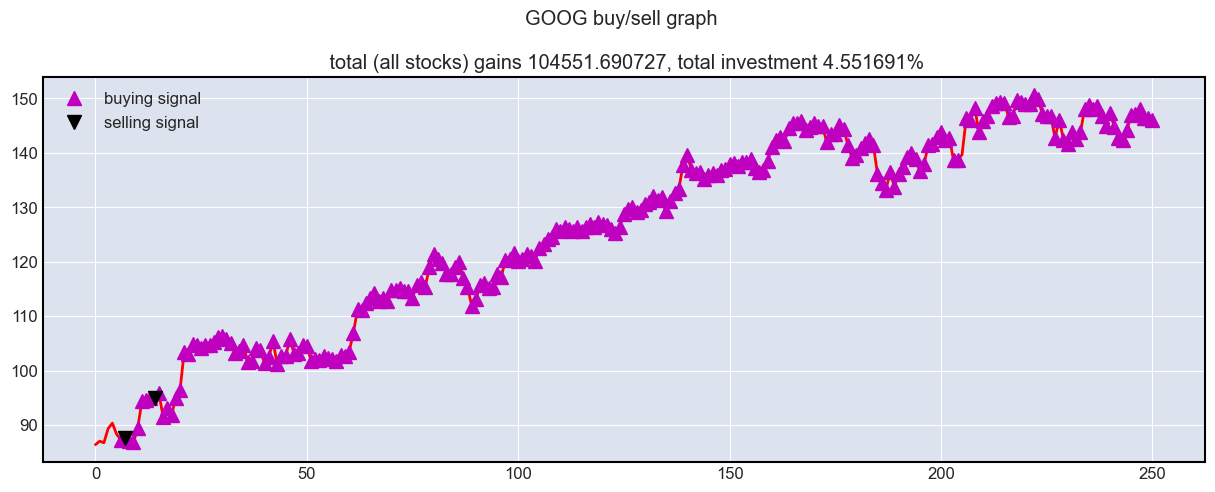

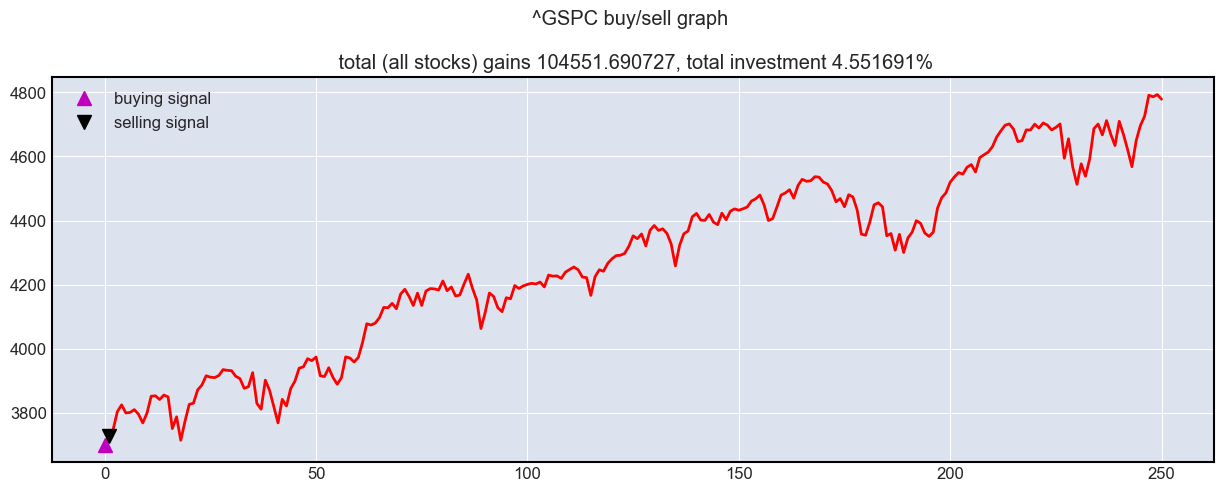

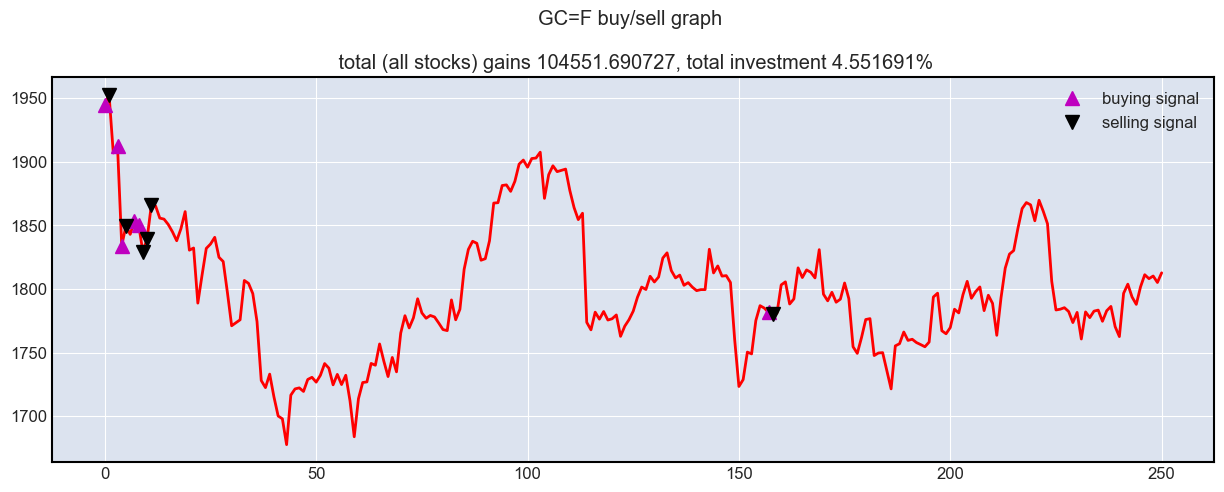

In [17]:
for ticker in tickers:
    test_trend_ticker = [t[ticker] for t in test_trend]
    fig = plt.figure(figsize = (15,5))
    plt.plot(test_trend_ticker, color='r', lw=2.)
    plt.plot(test_trend_ticker, '^', markersize=10, color='m', label = 'buying signal', markevery = test_states_buy[ticker])
    plt.plot(test_trend_ticker, 'v', markersize=10, color='k', label = 'selling signal', markevery = test_states_sell[ticker])
    plt.title(f'{ticker} buy/sell graph \n\n total (all stocks) gains %f, total investment %f%%'%(test_total_gains, test_invest))
    plt.legend()
    plt.show()

## Experiments

In this section of the notebook we will conduct the main experiment that is object of the paper: we will see if by changing the risk parameter the behaviour of the agent changes and the different volatility of the total results is statistically significant.
We will simulate testing on the same test data with different risk levels and compare the results. For each risk level we repeat the experiment X times and find the volatility. 

In [18]:
# Prepare the 'trend' data structure for training by renaming features to have ticker name in front
train_data_prefix = train_data.copy()
for ticker in tickers:
    train_data_prefix[ticker] = train_data_prefix[ticker].add_prefix(f'{ticker}_')
train_trend = [{ticker: train_data_prefix[ticker].iloc[t][f'{ticker}_Adj Close'] for ticker in tickers} for t in range(len(train_data[tickers[-1]]))]


In [28]:
## SECOND TEST SET DATA
start_date_test_2 = '2022-01-01' # Test Data start date
end_date_test_2 = '2022-12-31' # Test Data end date
test_data_2 = get_data(start_date_test_2, end_date_test_2, tickers)

# Identify common trade days for testing data and drop not in common
common_trade_days_test_2 = set(test_data_2[tickers[0]].index) # Initialize with the first ticker's dates
for ticker in tickers[1:]: # Loop through the rest of the tickers
    common_trade_days_test_2 = common_trade_days_test_2.intersection(set(test_data_2[ticker].index))
for ticker in tickers:
    test_data_2[ticker] = test_data_2[ticker].loc[list(common_trade_days_test_2)]

for ticker in tickers:
    test_data_2[ticker] = test_data_2[ticker].sort_index()
 
for ticker in tickers:
    # add daily_pct_change
    test_data_2[ticker]['daily_pct_change'] = (test_data_2[ticker]['Adj Close']- test_data_2[ticker]['Adj Close'].shift(-1))/test_data_2[ticker]['Adj Close'].shift(-1)*100
    # add mav
    for window in [3, 6, 9]:
        test_data_2[ticker][f'{window}d_mav'] = test_data_2[ticker]['Adj Close'].rolling(window=window).mean()

list_dates_test_2 = list(test_data_2[list(test_data_2.keys())[0]].index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [40]:
# Prepare the test_trend data structure from your test data
test_data_prefix = test_data.copy()
test_data_prefix = test_data_2.copy() # TO USE SECOND TEST SET
for ticker in tickers:
    test_data_prefix[ticker] = test_data_prefix[ticker].add_prefix(f'{ticker}_')

test_trend = [{ticker: test_data_prefix[ticker].iloc[t][f'{ticker}_Adj Close'] for ticker in tickers} for t in range(len(test_data_prefix[tickers[-1]]))]


In [41]:
risk_levels = [0, 1, 2]  # 0=low, 1=medium, 2=high
trials = 40
iterations = 1000
checkpoint = 10
initial_money = 100000

state_size=30  # 10 features * 3 stocks
window_size=10
trend=train_trend  # Use the test data structure
skip=1
batch_size=32

In [42]:
final_assets = {risk_level: [] for risk_level in risk_levels}
asset_paths = {risk_level: [] for risk_level in risk_levels}

for risk_level in risk_levels:
    print("Risk Level:", risk_level)
    print("\n")
    # Initialize a new agent instance
    agent = Trader(
    state_size=state_size,  # 10 features * 3 stocks
    window_size=window_size,
    trend=trend,  # Use the train_trend data structure
    skip=skip,
    batch_size=batch_size,
    tickers=tickers,
    transaction_cost=0.0
    )
    agent.set_risk_level(risk_level)
    agent.reset_inventory()
    # Train the agent
    #agent.train(iterations, checkpoint, initial_money)
    
    for trial in range(trials):
        print("---------------------------")
        print(f"Trial {trial + 1}")
        # Test the agent and store the final asset value
        _, _, total_assets, _, asset_path = agent.test(initial_money, test_trend)
        final_assets[risk_level].append(total_assets)
        asset_paths[risk_level].append(asset_path)


Risk Level: 0


---------------------------
Trial 1

Timestep 0:
Bought ^GSPC at price 3700.64990234375. New balance: 96299.35009765625

Timestep 1:
Bought GOOG at price 87.0459976196289. New balance: 96212.30410003662

Timestep 2:

Timestep 3:
Sold ^GSPC at price 3803.7900390625, profit: 103.14013671875. New balance: 100016.09413909912

Timestep 4:
Sold GOOG at price 90.3604965209961, profit: 3.3144989013671875. New balance: 100106.45463562012
Bought GC=F at price 1834.0999755859375. New balance: 98272.35466003418


/Users/Leonardo/opt/anaconda3/envs/advancedML/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/var/folders/5v/4rdq7jh96rvbvpkh2gls89p80000gp/T/ipykernel_16914/2112109697.py:48: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
/var/folders/5v/4rdq7jh96rvbvpkh2gls89p80000gp/T/ipykernel_16914/2112109697.py:49: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed2 = tf.layers.dense(feed, 256, activation = tf.nn.relu)
/var/folders/5v/4rdq7jh96rvbvpkh2gls89p80000gp/T/ip


Timestep 5:

Timestep 6:
Sold GC=F at price 1842.9000244140625, profit: 8.800048828125. New balance: 100115.25468444824

Timestep 7:

Timestep 8:

Timestep 9:
Bought GOOG at price 86.80950164794922. New balance: 100028.4451828003
Bought ^GSPC at price 3768.25. New balance: 96260.1951828003
Bought GC=F at price 1829.300048828125. New balance: 94430.89513397217

Timestep 10:
Sold GOOG at price 89.54299926757812, profit: 2.7334976196289062. New balance: 94520.43813323975
Sold ^GSPC at price 3798.909912109375, profit: 30.659912109375. New balance: 98319.34804534912

Timestep 11:

Timestep 12:

Timestep 13:

Timestep 14:

Timestep 15:

Timestep 16:

Timestep 17:
Bought GOOG at price 93.15550231933594. New balance: 98226.19254302979

Timestep 18:
Sold GOOG at price 91.78700256347656, profit: -1.368499755859375. New balance: 98317.97954559326
Sold GC=F at price 1847.300048828125, profit: 18.0. New balance: 100165.27959442139

Timestep 19:
Bought GOOG at price 95.06749725341797. New balance: 

In [43]:
risk_level_vol = {}
for risk_level, assets in final_assets.items():
    average = np.mean(assets)
    volatility = np.std(assets)
    risk_level_vol[risk_level] = volatility
    print(f"Risk Level {risk_level}: Avg Final Assets = {average:.2f}, Volatility = {volatility:.2f}")

Risk Level 0: Avg Final Assets = 100487.33, Volatility = 528.76
Risk Level 1: Avg Final Assets = 101402.45, Volatility = 578.26
Risk Level 2: Avg Final Assets = 109220.28, Volatility = 2921.82


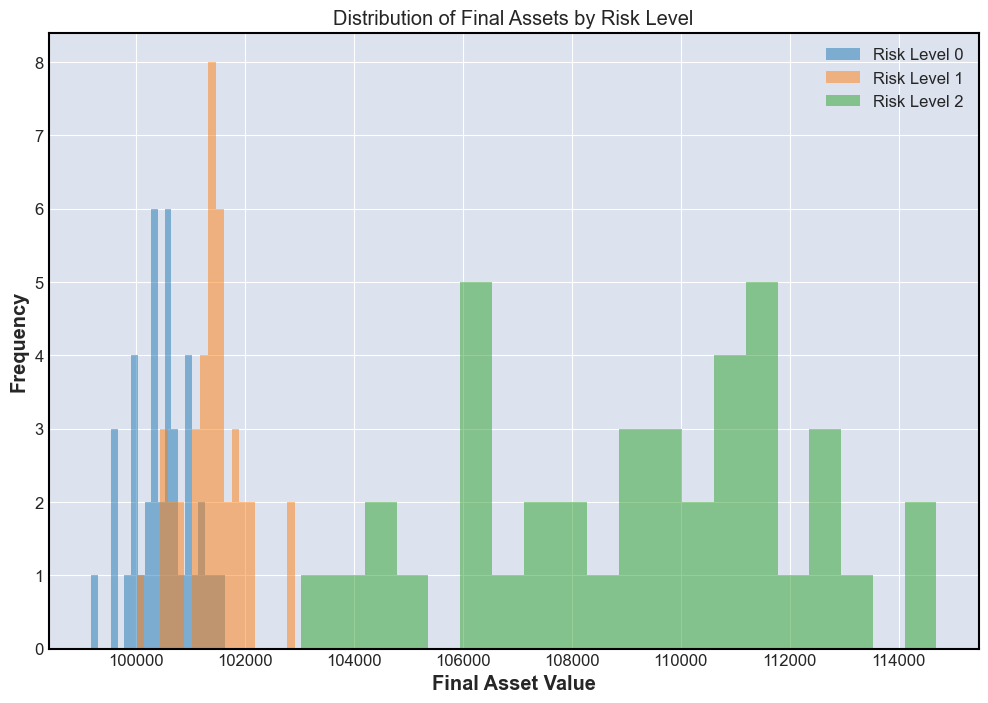

In [44]:
plt.figure(figsize=(12, 8))
for risk_level, assets in final_assets.items():
    plt.hist(assets, bins=20, alpha=0.5, label=f"Risk Level {risk_level}")

plt.title('Distribution of Final Assets by Risk Level')
plt.xlabel('Final Asset Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


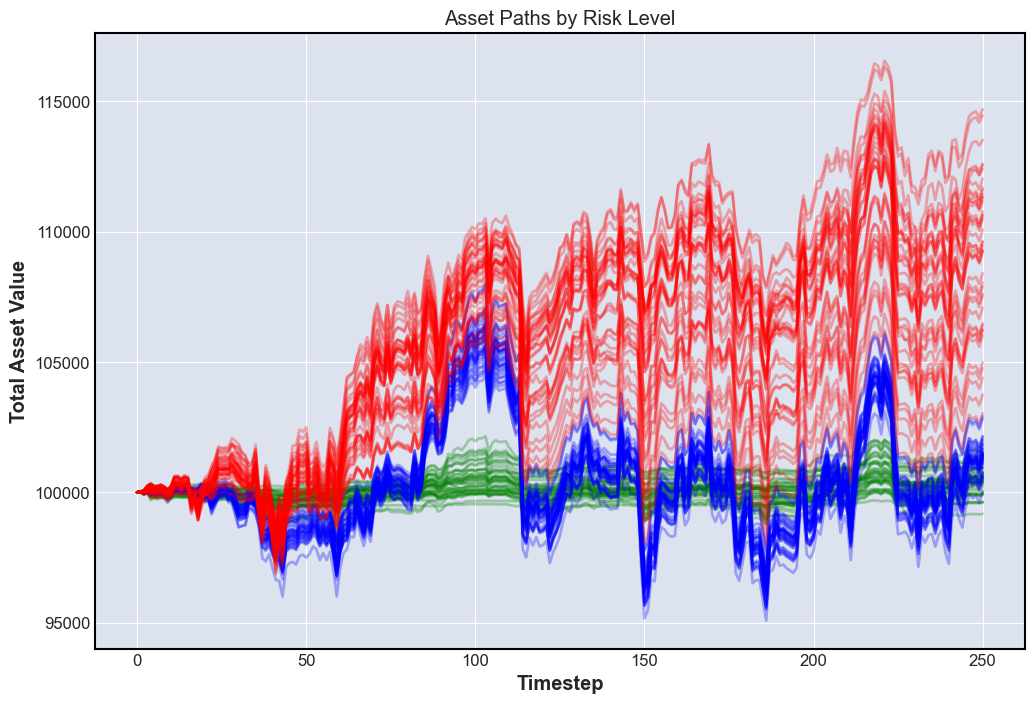

In [45]:
# Plot asset paths for each risk level

plt.figure(figsize=(12, 8))
colors = {0: 'green', 1: 'blue', 2: 'red'}  # Assign colors to risk levels

for risk_level, paths in asset_paths.items():
    for path in paths:
        plt.plot(path, color=colors[risk_level], alpha=0.3)  # Use alpha to manage line transparency


plt.title('Asset Paths by Risk Level')
plt.xlabel('Timestep')
plt.ylabel('Total Asset Value')
plt.legend(loc='upper left')
plt.show()


In [46]:
def compute_path_volatility(path):
    returns = np.diff(path) / path[:-1]
    volatility = np.std(returns)
    return volatility

# Compute path volatility for each path
path_volatility = {risk_level: [compute_path_volatility(path) for path in paths] for risk_level, paths in asset_paths.items()}

# Perform ANOVA test to analyze statistical differences
f_stat, p_value = f_oneway(*path_volatility.values())
print(f"ANOVA test result: F-statistic = {f_stat}, p-value = {p_value}")
if p_value < 0.05:
    print("There is a significant difference between the volatility of asset paths across different risk levels.")
else:
    print("There is no significant difference between the volatility of asset paths across different risk levels.")

# Calculate average volatility for each risk level and display in a DataFrame
average_volatility = {risk_level: np.mean(volatilities) for risk_level, volatilities in path_volatility.items()}
average_volatility_df = pd.DataFrame(list(average_volatility.items()), columns=['Risk Level', 'Average Volatility'])
print(average_volatility_df)

ANOVA test result: F-statistic = 2485.6362281869974, p-value = 1.4272727387325812e-96
There is a significant difference between the volatility of asset paths across different risk levels.
   Risk Level  Average Volatility
0           0            0.000921
1           1            0.007041
2           2            0.006264
